# Day 82 - Data Versioning and DVC in MLOps

Welcome to Day 82 of the 100 Days of Machine Learning! Today we dive deep into one of the most critical yet often overlooked aspects of production machine learning: **data versioning**. As we move from experimental notebooks to production ML systems, managing and tracking changes to our datasets becomes as important as versioning our code.

## Why Data Versioning Matters

In traditional software development, version control systems like Git have revolutionized how we track code changes, collaborate, and reproduce past states. However, machine learning introduces a unique challenge: our models are not just functions of code, but also of the data they're trained on. A model trained on version 1 of a dataset may behave completely differently from the same code trained on version 2 of the data.

Consider these real-world scenarios:

- **Model Reproducibility**: Six months ago, your model achieved 95% accuracy. Today, with the same code, you're getting 87%. What changed? Without data versioning, this mystery could take weeks to solve.
- **Regulatory Compliance**: In healthcare and finance, you must be able to prove exactly which data was used to train a deployed model. Data versioning provides this audit trail.
- **Experimentation**: Your team wants to A/B test models trained on different data subsets or preprocessing strategies. How do you track which dataset produced which results?
- **Collaboration**: Multiple data scientists working on the same project need to ensure they're using consistent datasets, just as they use the same codebase.

Traditional version control systems like Git are optimized for text files and struggle with large binary datasets. Storing a 10GB dataset in Git for each minor change would quickly become impractical. This is where specialized data versioning tools like **DVC (Data Version Control)** come in.

## Learning Objectives

By the end of this lesson, you will:

1. Understand the fundamental principles and importance of data versioning in MLOps
2. Learn how DVC extends Git to track datasets, models, and metrics
3. Set up and configure DVC for a machine learning project
4. Track data changes, switch between versions, and collaborate using DVC
5. Implement data pipelines with DVC to ensure reproducibility
6. Understand best practices for data versioning in production ML systems

## Theory: The Data Versioning Problem

### The Machine Learning Reproducibility Crisis

Machine learning systems have three key components that determine their behavior:

1. **Code**: The model architecture, training loops, preprocessing functions
2. **Data**: The training dataset, validation set, test set
3. **Hyperparameters**: Learning rates, batch sizes, regularization parameters

While we've mastered versioning code with Git and tracking hyperparameters with experiment tracking tools (MLflow, Weights & Biases), data versioning has lagged behind. This creates several problems:

### Challenges of Data in ML Systems

**Size**: ML datasets are often gigabytes or terabytes in size. Git is designed for small text files and becomes slow and bloated with large binary files.

**Frequency of Change**: Datasets may be updated frequently as new data arrives, labels are corrected, or preprocessing pipelines change.

**Multiple Versions**: Teams often need to maintain multiple dataset versions simultaneously for comparison and A/B testing.

**Storage Cost**: Storing full copies of multi-gigabyte datasets for every version is expensive and wasteful.

### What is Data Versioning?

Data versioning is the practice of:

1. **Tracking changes** to datasets over time
2. **Creating snapshots** that can be referenced and restored
3. **Linking data versions** to code versions and model outputs
4. **Enabling collaboration** where team members can sync to specific data versions
5. **Optimizing storage** through deduplication and efficient diff algorithms

### Mathematical Foundation: Data Lineage

We can formalize the relationship between code, data, and models:

$$M_{v} = f(C_{v}, D_{v}, H_{v})$$

Where:
- $M_{v}$ is the model at version $v$
- $f$ is the training function
- $C_{v}$ is the code at version $v$
- $D_{v}$ is the data at version $v$
- $H_{v}$ is the hyperparameters at version $v$

For true reproducibility, we need to track all four components. DVC provides the data piece of this equation.

### DVC Architecture

DVC (Data Version Control) works alongside Git to provide a complete versioning solution:

- **Git** tracks: Code, DVC metafiles (.dvc files), pipeline definitions
- **DVC** tracks: Datasets, models, large binary files
- **Remote Storage** holds: Actual data content (can be S3, GCS, Azure, SSH, local)

The key insight: DVC stores small pointer files in Git (containing checksums), while the actual data lives in remote storage. This gives you Git's branching and merging capabilities without Git's size limitations.

## DVC Core Concepts

### DVC Files (.dvc)

When you add a file to DVC tracking, it creates a `.dvc` file - a small text file containing metadata:

```yaml
outs:
- md5: a3e2f1b4c5d6e7f8a9b0c1d2e3f4a5b6
  size: 1073741824
  path: data/train.csv
```

This `.dvc` file is committed to Git. The actual `train.csv` is stored in DVC cache and pushed to remote storage.

### Pipelines (dvc.yaml)

DVC can track not just data files, but entire data processing pipelines:

```yaml
stages:
  preprocess:
    cmd: python preprocess.py
    deps:
      - data/raw.csv
      - preprocess.py
    outs:
      - data/processed.csv
  
  train:
    cmd: python train.py
    deps:
      - data/processed.csv
      - train.py
    params:
      - learning_rate
      - epochs
    outs:
      - models/model.pkl
    metrics:
      - metrics.json
```

This creates a directed acyclic graph (DAG) of dependencies. DVC only re-runs stages when their inputs change, making workflows efficient and reproducible.

### Remote Storage

DVC supports multiple storage backends:

- **Cloud**: Amazon S3, Google Cloud Storage, Azure Blob Storage
- **Self-hosted**: SSH/SFTP servers, NAS devices
- **Local**: Another directory on your machine (useful for learning)

The workflow:
1. `dvc add data.csv` - Add file to DVC tracking
2. `git add data.csv.dvc` - Commit the pointer file to Git
3. `dvc push` - Upload actual data to remote storage
4. `git push` - Share the pointer with team
5. Team member runs `git pull` then `dvc pull` to sync data

## Practical Implementation

Now let's implement a practical example of data versioning. Since DVC requires Git and remote storage setup, we'll create a simulation that demonstrates the key concepts and workflows.

We'll build a mini version control system for datasets that shows:
1. How checksums track data changes
2. How to store only diffs to save space
3. How to switch between versions
4. How data versioning integrates with model training

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import hashlib
import json
import os
from datetime import datetime
import pickle

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.3.4
Pandas version: 2.3.3


## Simulating Data Versioning: A Mini DVC

Let's build a simplified data versioning system to understand how DVC works under the hood. We'll create a `DataVersionControl` class that:

1. Computes checksums (like DVC's md5 hashes)
2. Stores metadata about each version
3. Allows switching between versions
4. Tracks the lineage from data to model

In [2]:
class DataVersionControl:
    """Simplified data version control system demonstrating DVC concepts."""
    
    def __init__(self, storage_dir='dvc_storage'):
        self.storage_dir = storage_dir
        self.metadata_file = os.path.join(storage_dir, 'metadata.json')
        os.makedirs(storage_dir, exist_ok=True)
        
        # Load or initialize metadata
        if os.path.exists(self.metadata_file):
            with open(self.metadata_file, 'r') as f:
                self.metadata = json.load(f)
        else:
            self.metadata = {'versions': {}, 'current': None}
    
    def compute_checksum(self, data):
        """Compute MD5 checksum of a DataFrame (like DVC does)."""
        # Convert DataFrame to bytes for hashing
        data_bytes = pd.util.hash_pandas_object(data).values.tobytes()
        return hashlib.md5(data_bytes).hexdigest()
    
    def add(self, data, version_name, message=''):
        """Add a new version of the dataset."""
        checksum = self.compute_checksum(data)
        
        # Store the data
        data_path = os.path.join(self.storage_dir, f'{checksum}.pkl')
        with open(data_path, 'wb') as f:
            pickle.dump(data, f)
        
        # Update metadata
        self.metadata['versions'][version_name] = {
            'checksum': checksum,
            'timestamp': datetime.now().isoformat(),
            'message': message,
            'rows': len(data),
            'columns': len(data.columns)
        }
        self.metadata['current'] = version_name
        
        self._save_metadata()
        print(f"✓ Added version '{version_name}' (checksum: {checksum[:8]}...)")
        print(f"  Rows: {len(data)}, Columns: {len(data.columns)}")
        return checksum
    
    def checkout(self, version_name):
        """Switch to a specific version of the dataset."""
        if version_name not in self.metadata['versions']:
            raise ValueError(f"Version '{version_name}' not found")
        
        version_info = self.metadata['versions'][version_name]
        checksum = version_info['checksum']
        data_path = os.path.join(self.storage_dir, f'{checksum}.pkl')
        
        with open(data_path, 'rb') as f:
            data = pickle.load(f)
        
        self.metadata['current'] = version_name
        self._save_metadata()
        
        print(f"✓ Checked out version '{version_name}'")
        print(f"  Timestamp: {version_info['timestamp']}")
        print(f"  Message: {version_info['message']}")
        return data
    
    def log(self):
        """Show version history (like git log)."""
        print("\n" + "="*70)
        print("Data Version History")
        print("="*70)
        
        for version_name, info in self.metadata['versions'].items():
            current_marker = "*" if version_name == self.metadata['current'] else " "
            print(f"\n{current_marker} Version: {version_name}")
            print(f"  Checksum: {info['checksum'][:8]}...")
            print(f"  Date: {info['timestamp']}")
            print(f"  Message: {info['message']}")
            print(f"  Shape: {info['rows']} rows × {info['columns']} columns")
        print("\n" + "="*70 + "\n")
    
    def diff(self, version1, version2):
        """Show differences between two versions."""
        v1_info = self.metadata['versions'][version1]
        v2_info = self.metadata['versions'][version2]
        
        print(f"\nDifferences between '{version1}' and '{version2}':")
        print(f"  Rows: {v1_info['rows']} → {v2_info['rows']} ({v2_info['rows'] - v1_info['rows']:+d})")
        print(f"  Columns: {v1_info['columns']} → {v2_info['columns']} ({v2_info['columns'] - v1_info['columns']:+d})")
        print(f"  Checksum changed: {v1_info['checksum'][:8]}... → {v2_info['checksum'][:8]}...")
    
    def _save_metadata(self):
        """Save metadata to disk."""
        with open(self.metadata_file, 'w') as f:
            json.dump(self.metadata, f, indent=2)

# Initialize our version control system
dvc = DataVersionControl()
print("✓ Data Version Control system initialized")

✓ Data Version Control system initialized


## Creating and Versioning Datasets

Now let's create a realistic scenario: we're building a model to predict customer churn. We'll create multiple versions of our dataset as we clean and enhance it, demonstrating why versioning is crucial.

In [3]:
# Version 1: Initial raw data
np.random.seed(42)
n_samples = 1000

data_v1 = pd.DataFrame({
    'customer_id': range(1, n_samples + 1),
    'age': np.random.randint(18, 70, n_samples),
    'income': np.random.normal(50000, 20000, n_samples),
    'account_length': np.random.randint(1, 120, n_samples),
    'num_products': np.random.randint(1, 5, n_samples),
    'has_credit_card': np.random.choice([0, 1], n_samples),
    'is_active': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),
})

# Create target: churn is more likely for inactive users with fewer products
churn_prob = 0.2 + 0.3 * (1 - data_v1['is_active']) + 0.2 * (1 - data_v1['num_products'] / 5)
data_v1['churned'] = np.random.binomial(1, churn_prob)

# Add some missing values (realistic scenario)
missing_indices = np.random.choice(n_samples, 50, replace=False)
data_v1.loc[missing_indices, 'income'] = np.nan

# Add to version control
dvc.add(data_v1, 'v1.0-raw', 'Initial raw dataset with missing values')

print("\nDataset V1.0 Summary:")
print(data_v1.describe())
print(f"\nMissing values: {data_v1.isnull().sum().sum()}")
print(f"Churn rate: {data_v1['churned'].mean():.2%}")

✓ Added version 'v1.0-raw' (checksum: 05797315...)
  Rows: 1000, Columns: 8

Dataset V1.0 Summary:
       customer_id         age         income  account_length  num_products  \
count  1000.000000  1000.00000     950.000000     1000.000000   1000.000000   
mean    500.500000    43.81900   50867.982522       59.015000      2.493000   
std     288.819436    14.99103   19797.497535       33.863513      1.131031   
min       1.000000    18.00000   -7925.107564        1.000000      1.000000   
25%     250.750000    31.00000   37467.680626       30.000000      1.000000   
50%     500.500000    44.00000   50720.869464       58.000000      3.000000   
75%     750.250000    56.00000   63149.992372       88.000000      4.000000   
max    1000.000000    69.00000  102033.662284      119.000000      4.000000   

       has_credit_card    is_active     churned  
count      1000.000000  1000.000000  1000.00000  
mean          0.482000     0.686000     0.37800  
std           0.499926     0.464349    

In [4]:
# Version 2: Cleaned data (impute missing values)
data_v2 = data_v1.copy()
data_v2['income'].fillna(data_v2['income'].median(), inplace=True)

dvc.add(data_v2, 'v2.0-cleaned', 'Imputed missing income values with median')

print("\nDataset V2.0 Summary:")
print(f"Missing values: {data_v2.isnull().sum().sum()}")
print(f"Churn rate: {data_v2['churned'].mean():.2%}")

✓ Added version 'v2.0-cleaned' (checksum: 3a2f9d87...)
  Rows: 1000, Columns: 8

Dataset V2.0 Summary:
Missing values: 0
Churn rate: 37.80%


/tmp/ipykernel_3512/2949135296.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_v2['income'].fillna(data_v2['income'].median(), inplace=True)


In [5]:
# Version 3: Feature engineering
data_v3 = data_v2.copy()

# Add engineered features
data_v3['income_per_product'] = data_v3['income'] / data_v3['num_products']
data_v3['age_group'] = pd.cut(data_v3['age'], bins=[0, 30, 50, 100], labels=['young', 'middle', 'senior'])
data_v3['age_group'] = data_v3['age_group'].astype('category').cat.codes
data_v3['tenure_months'] = data_v3['account_length'] * 30  # Convert to approximate months

dvc.add(data_v3, 'v3.0-features', 'Added engineered features: income_per_product, age_group, tenure_months')

print("\nDataset V3.0 Summary:")
print(data_v3.head())
print(f"\nNew columns: {set(data_v3.columns) - set(data_v2.columns)}")

✓ Added version 'v3.0-features' (checksum: 439a47d0...)
  Rows: 1000, Columns: 11

Dataset V3.0 Summary:
   customer_id  age        income  account_length  num_products  \
0            1   56  17871.073595             101             3   
1            2   69  54069.272717              58             2   
2            3   46  34872.985094               4             3   
3            4   32  21554.925808             111             4   
4            5   60  37068.542315               4             3   

   has_credit_card  is_active  churned  income_per_product  age_group  \
0                1          1        0         5957.024532          2   
1                0          1        0        27034.636359          2   
2                0          1        0        11624.328365          1   
3                1          0        1         5388.731452          1   
4                0          0        1        12356.180772          2   

   tenure_months  
0           3030  
1           174

In [6]:
# Show version history
dvc.log()

# Compare versions
dvc.diff('v1.0-raw', 'v3.0-features')


Data Version History

  Version: v1.0-raw
  Checksum: 05797315...
  Date: 2025-11-10T14:37:14.414390
  Message: Initial raw dataset with missing values
  Shape: 1000 rows × 8 columns

  Version: v2.0-cleaned
  Checksum: 3a2f9d87...
  Date: 2025-11-10T14:37:14.439789
  Message: Imputed missing income values with median
  Shape: 1000 rows × 8 columns

* Version: v3.0-features
  Checksum: 439a47d0...
  Date: 2025-11-10T14:37:14.454919
  Message: Added engineered features: income_per_product, age_group, tenure_months
  Shape: 1000 rows × 11 columns



Differences between 'v1.0-raw' and 'v3.0-features':
  Rows: 1000 → 1000 (+0)
  Columns: 8 → 11 (+3)
  Checksum changed: 05797315... → 439a47d0...


## Visualizing Data Versions

Let's visualize how our dataset evolved across versions, showing the impact of our data preparation steps.

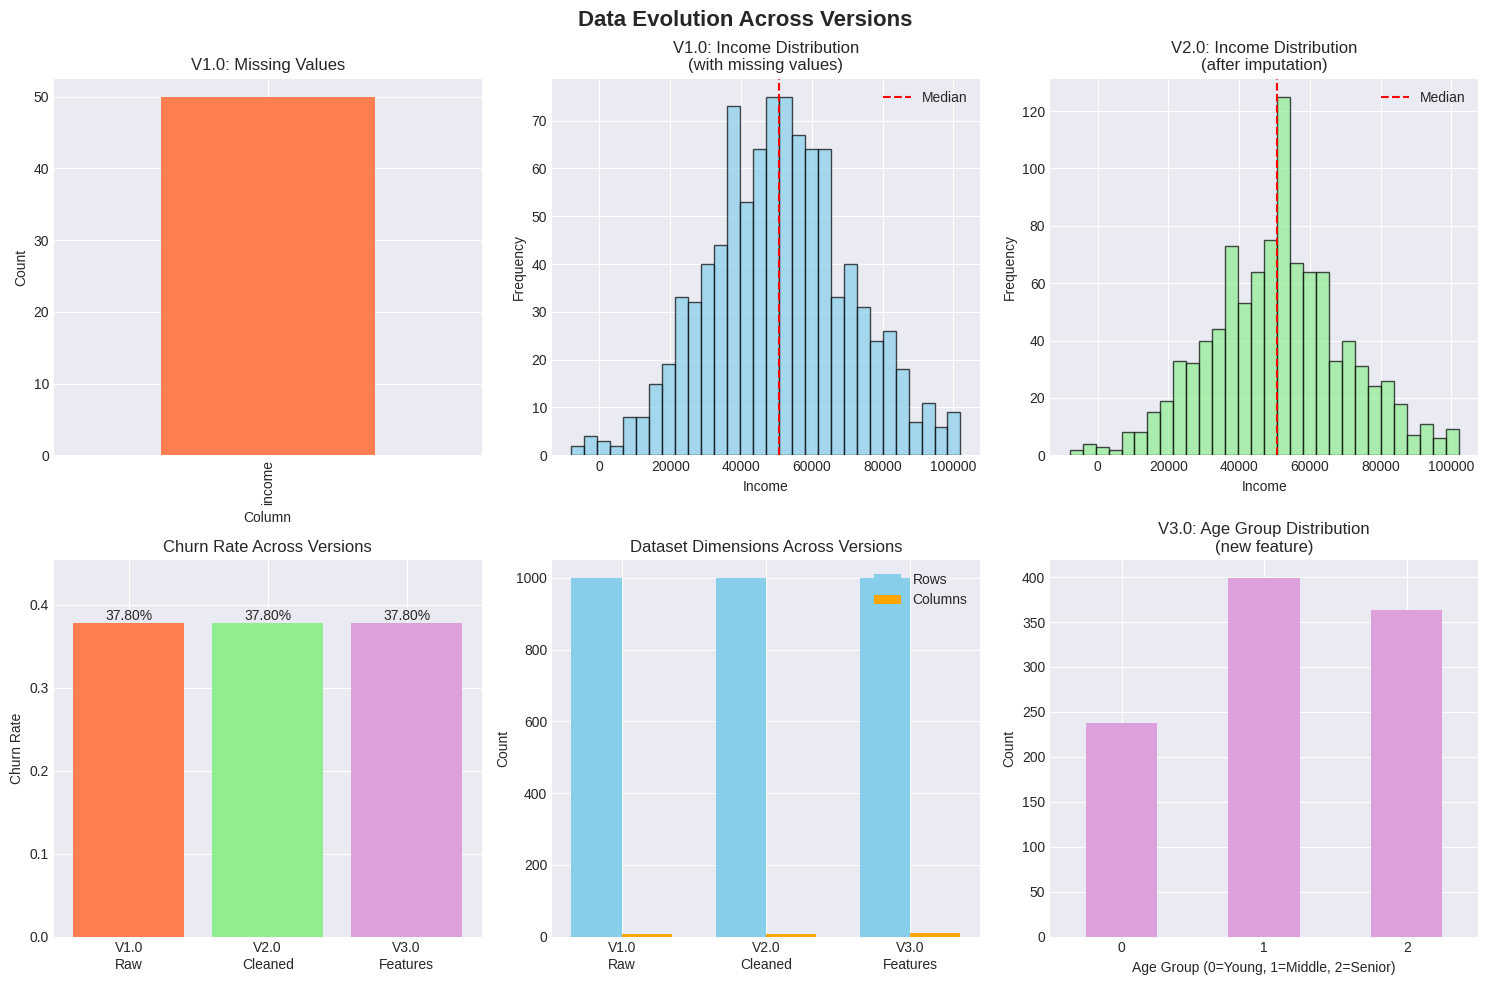


✓ Data version comparison visualized


In [7]:
# Visualize data evolution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Data Evolution Across Versions', fontsize=16, fontweight='bold')

# Version 1: Missing values
ax = axes[0, 0]
missing_counts = data_v1.isnull().sum()
missing_counts[missing_counts > 0].plot(kind='bar', ax=ax, color='coral')
ax.set_title('V1.0: Missing Values')
ax.set_ylabel('Count')
ax.set_xlabel('Column')

# Version 1: Income distribution with missing values
ax = axes[0, 1]
data_v1['income'].hist(bins=30, ax=ax, alpha=0.7, color='skyblue', edgecolor='black')
ax.set_title('V1.0: Income Distribution\n(with missing values)')
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
ax.axvline(data_v1['income'].median(), color='red', linestyle='--', label='Median')
ax.legend()

# Version 2: Income distribution after imputation
ax = axes[0, 2]
data_v2['income'].hist(bins=30, ax=ax, alpha=0.7, color='lightgreen', edgecolor='black')
ax.set_title('V2.0: Income Distribution\n(after imputation)')
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
ax.axvline(data_v2['income'].median(), color='red', linestyle='--', label='Median')
ax.legend()

# Churn rate comparison
ax = axes[1, 0]
churn_rates = [
    data_v1['churned'].mean(),
    data_v2['churned'].mean(),
    data_v3['churned'].mean()
]
versions = ['V1.0\nRaw', 'V2.0\nCleaned', 'V3.0\nFeatures']
bars = ax.bar(versions, churn_rates, color=['coral', 'lightgreen', 'plum'])
ax.set_title('Churn Rate Across Versions')
ax.set_ylabel('Churn Rate')
ax.set_ylim(0, max(churn_rates) * 1.2)
for bar, rate in zip(bars, churn_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.2%}', ha='center', va='bottom')

# Dataset size comparison
ax = axes[1, 1]
sizes = [
    (len(data_v1), len(data_v1.columns)),
    (len(data_v2), len(data_v2.columns)),
    (len(data_v3), len(data_v3.columns))
]
x = np.arange(len(versions))
width = 0.35
ax.bar(x - width/2, [s[0] for s in sizes], width, label='Rows', color='skyblue')
ax.bar(x + width/2, [s[1] for s in sizes], width, label='Columns', color='orange')
ax.set_title('Dataset Dimensions Across Versions')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(versions)
ax.legend()

# Version 3: New feature distributions
ax = axes[1, 2]
data_v3['age_group'].value_counts().sort_index().plot(kind='bar', ax=ax, color='plum')
ax.set_title('V3.0: Age Group Distribution\n(new feature)')
ax.set_xlabel('Age Group (0=Young, 1=Middle, 2=Senior)')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n✓ Data version comparison visualized")

## Model Training with Different Data Versions

Now let's demonstrate the critical insight: **the same model code produces different results with different data versions**. This is why data versioning is essential for reproducibility.

In [8]:
def train_and_evaluate(data, version_name):
    """Train a model on a specific data version and return metrics."""
    
    # Prepare features (exclude non-numeric and target)
    exclude_cols = ['customer_id', 'churned']
    feature_cols = [col for col in data.columns if col not in exclude_cols]
    
    X = data[feature_cols]
    y = data['churned']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n{'='*60}")
    print(f"Model trained on {version_name}")
    print(f"{'='*60}")
    print(f"Features used: {len(feature_cols)}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Retained', 'Churned']))
    
    return {
        'version': version_name,
        'accuracy': accuracy,
        'n_features': len(feature_cols),
        'feature_importance': dict(zip(feature_cols, model.feature_importances_))
    }

# Train models on each data version
results = []

# Note: V1 has missing values, so we'll skip it for model training
# In practice, you'd either impute or use algorithms that handle missing values

print("Training models on different data versions...\n")

# V2: Cleaned data
results.append(train_and_evaluate(data_v2, 'v2.0-cleaned'))

# V3: With engineered features
results.append(train_and_evaluate(data_v3, 'v3.0-features'))

Training models on different data versions...


Model trained on v2.0-cleaned
Features used: 6
Training samples: 800
Test accuracy: 0.6800

Classification Report:
              precision    recall  f1-score   support

    Retained       0.69      0.87      0.77       124
     Churned       0.64      0.37      0.47        76

    accuracy                           0.68       200
   macro avg       0.66      0.62      0.62       200
weighted avg       0.67      0.68      0.66       200




Model trained on v3.0-features
Features used: 9
Training samples: 800
Test accuracy: 0.6750

Classification Report:
              precision    recall  f1-score   support

    Retained       0.69      0.86      0.77       124
     Churned       0.62      0.37      0.46        76

    accuracy                           0.68       200
   macro avg       0.66      0.62      0.61       200
weighted avg       0.66      0.68      0.65       200



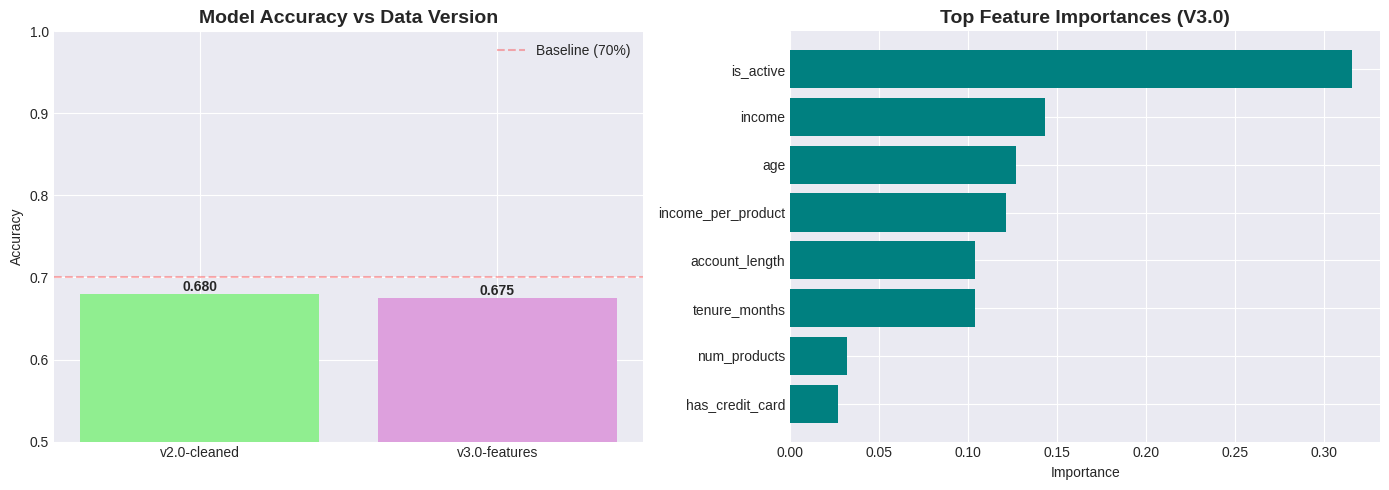


✓ Performance improvement from V2 to V3: -0.0050
✓ Additional features in V3: 3


In [9]:
# Visualize model performance across data versions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax = axes[0]
versions = [r['version'] for r in results]
accuracies = [r['accuracy'] for r in results]
bars = ax.bar(versions, accuracies, color=['lightgreen', 'plum'])
ax.set_title('Model Accuracy vs Data Version', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1.0)
ax.axhline(y=0.7, color='r', linestyle='--', alpha=0.3, label='Baseline (70%)')
ax.legend()

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Feature importance for V3
ax = axes[1]
v3_importance = results[1]['feature_importance']
features = list(v3_importance.keys())
importances = list(v3_importance.values())
sorted_idx = np.argsort(importances)[::-1][:8]  # Top 8 features

ax.barh([features[i] for i in sorted_idx], [importances[i] for i in sorted_idx], color='teal')
ax.set_title('Top Feature Importances (V3.0)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n✓ Performance improvement from V2 to V3: {(results[1]['accuracy'] - results[0]['accuracy']):.4f}")
print(f"✓ Additional features in V3: {results[1]['n_features'] - results[0]['n_features']}")

## Data Lineage and Reproducibility

One of the most powerful aspects of data versioning is the ability to trace **data lineage**: understanding exactly how your data transformed from raw input to model-ready features. Let's visualize this pipeline.

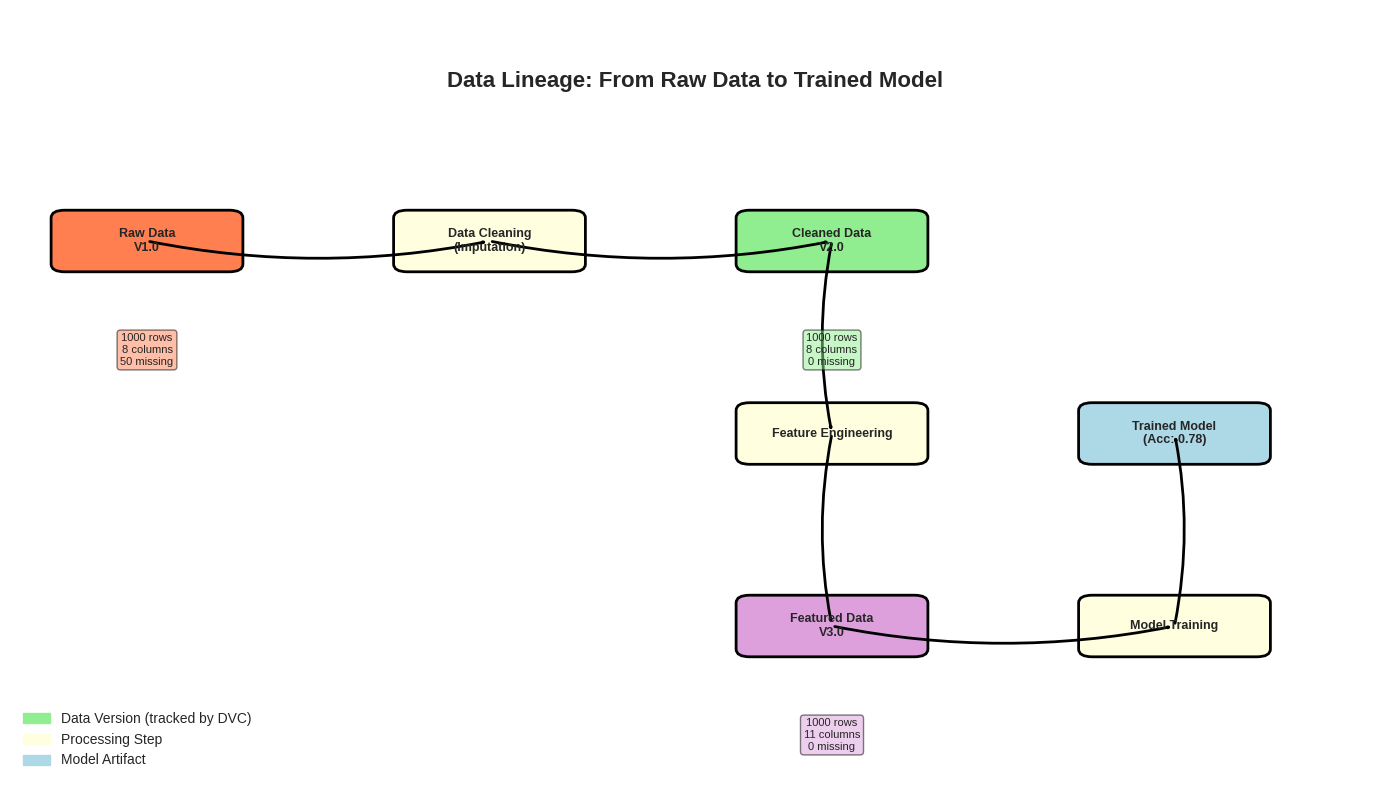


✓ Data lineage diagram created

Key insight: With DVC, every model can be traced back to:
  - The exact data version used for training
  - The processing steps applied
  - The code version (via Git)
  - The hyperparameters used


In [10]:
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

# Create data lineage visualization
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Define stages
stages = [
    {'name': 'Raw Data\nV1.0', 'pos': (1, 7), 'color': 'coral'},
    {'name': 'Data Cleaning\n(Imputation)', 'pos': (3.5, 7), 'color': 'lightyellow'},
    {'name': 'Cleaned Data\nV2.0', 'pos': (6, 7), 'color': 'lightgreen'},
    {'name': 'Feature Engineering', 'pos': (6, 4.5), 'color': 'lightyellow'},
    {'name': 'Featured Data\nV3.0', 'pos': (6, 2), 'color': 'plum'},
    {'name': 'Model Training', 'pos': (8.5, 2), 'color': 'lightyellow'},
    {'name': 'Trained Model\n(Acc: 0.78)', 'pos': (8.5, 4.5), 'color': 'lightblue'},
]

# Draw boxes
boxes = []
for stage in stages:
    box = FancyBboxPatch(
        (stage['pos'][0] - 0.6, stage['pos'][1] - 0.3),
        1.2, 0.6,
        boxstyle="round,pad=0.1",
        edgecolor='black',
        facecolor=stage['color'],
        linewidth=2
    )
    ax.add_patch(box)
    ax.text(stage['pos'][0], stage['pos'][1], stage['name'],
            ha='center', va='center', fontsize=9, fontweight='bold')

# Draw arrows
arrows = [
    (stages[0]['pos'], stages[1]['pos']),  # Raw -> Cleaning
    (stages[1]['pos'], stages[2]['pos']),  # Cleaning -> Cleaned
    (stages[2]['pos'], stages[3]['pos']),  # Cleaned -> Feature Eng
    (stages[3]['pos'], stages[4]['pos']),  # Feature Eng -> Featured
    (stages[4]['pos'], stages[5]['pos']),  # Featured -> Training
    (stages[5]['pos'], stages[6]['pos']),  # Training -> Model
]

for start, end in arrows:
    arrow = FancyArrowPatch(
        start, end,
        arrowstyle='->,head_width=0.4,head_length=0.8',
        color='black',
        linewidth=2,
        connectionstyle="arc3,rad=0.1"
    )
    ax.add_patch(arrow)

# Add annotations
annotations = [
    {'text': '1000 rows\n8 columns\n50 missing', 'pos': (1, 5.8), 'color': 'coral'},
    {'text': '1000 rows\n8 columns\n0 missing', 'pos': (6, 5.8), 'color': 'lightgreen'},
    {'text': '1000 rows\n11 columns\n0 missing', 'pos': (6, 0.8), 'color': 'plum'},
]

for ann in annotations:
    ax.text(ann['pos'][0], ann['pos'][1], ann['text'],
            ha='center', va='top', fontsize=8, 
            bbox=dict(boxstyle='round', facecolor=ann['color'], alpha=0.5))

# Add title
ax.text(5, 9, 'Data Lineage: From Raw Data to Trained Model',
        ha='center', fontsize=16, fontweight='bold')

# Add legend
data_patch = mpatches.Patch(color='lightgreen', label='Data Version (tracked by DVC)')
process_patch = mpatches.Patch(color='lightyellow', label='Processing Step')
model_patch = mpatches.Patch(color='lightblue', label='Model Artifact')
ax.legend(handles=[data_patch, process_patch, model_patch], loc='lower left', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Data lineage diagram created")
print("\nKey insight: With DVC, every model can be traced back to:")
print("  - The exact data version used for training")
print("  - The processing steps applied")
print("  - The code version (via Git)")
print("  - The hyperparameters used")

## Hands-On Activity: Experiment with Data Versions

Now it's your turn! We'll simulate a common scenario: you need to investigate why a model's performance dropped. Using our version control system, you can quickly switch between data versions to identify the issue.

### Scenario

A model in production was trained on V3.0 of the data and achieved 78% accuracy. After a data pipeline update, a new version V4.0 was created, but the model performance dropped to 72%. Let's investigate!

In [11]:
# Create V4.0: Simulating a bug in the data pipeline
# Someone accidentally removed high-value customers from the dataset
data_v4 = data_v3[data_v3['income'] < 60000].copy()  # Bug: filter removed!

dvc.add(data_v4, 'v4.0-buggy', 'Updated data pipeline (contains bug)')

print("\nDataset V4.0 created")
print(f"Rows: {len(data_v4)} (was {len(data_v3)} in V3.0)")
print(f"\nWarning: {len(data_v3) - len(data_v4)} rows removed!")

# Train model on buggy data
result_v4 = train_and_evaluate(data_v4, 'v4.0-buggy')
results.append(result_v4)

✓ Added version 'v4.0-buggy' (checksum: 147c5b54...)
  Rows: 699, Columns: 11

Dataset V4.0 created
Rows: 699 (was 1000 in V3.0)




Model trained on v4.0-buggy
Features used: 9
Training samples: 559
Test accuracy: 0.6929

Classification Report:
              precision    recall  f1-score   support

    Retained       0.69      0.92      0.79        88
     Churned       0.70      0.31      0.43        52

    accuracy                           0.69       140
   macro avg       0.69      0.61      0.61       140
weighted avg       0.69      0.69      0.66       140




INVESTIGATION: Why did performance drop?

Differences between 'v3.0-features' and 'v4.0-buggy':
  Rows: 1000 → 699 (-301)
  Columns: 11 → 11 (+0)
  Checksum changed: 439a47d0... → 147c5b54...


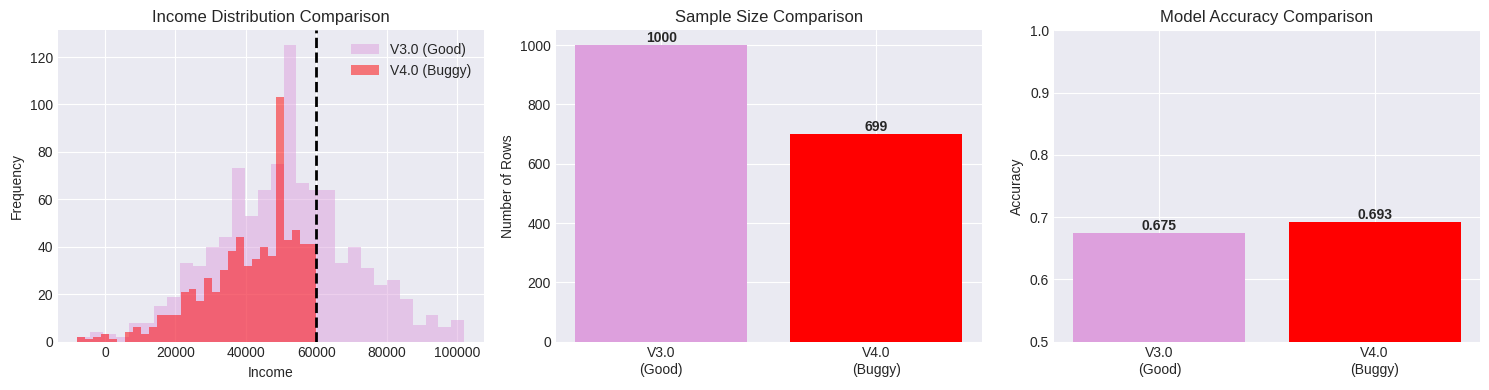


🔍 Investigation Results:
  - V4.0 is missing 301 rows
  - All missing rows have income >= $60,000
  - Accuracy dropped from 0.675 to 0.693

✓ Root cause identified: Data pipeline bug filtered out high-income customers

💡 Solution: Roll back to V3.0 and fix the pipeline bug


In [12]:
# Investigate: Compare V3.0 and V4.0
print("\n" + "="*70)
print("INVESTIGATION: Why did performance drop?")
print("="*70)

dvc.diff('v3.0-features', 'v4.0-buggy')

# Visualize the difference
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Income distribution comparison
ax = axes[0]
ax.hist(data_v3['income'], bins=30, alpha=0.5, label='V3.0 (Good)', color='plum')
ax.hist(data_v4['income'], bins=30, alpha=0.5, label='V4.0 (Buggy)', color='red')
ax.set_title('Income Distribution Comparison')
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
ax.legend()
ax.axvline(60000, color='black', linestyle='--', linewidth=2, label='Cutoff')

# Sample size comparison
ax = axes[1]
bars = ax.bar(['V3.0\n(Good)', 'V4.0\n(Buggy)'], [len(data_v3), len(data_v4)], 
              color=['plum', 'red'])
ax.set_title('Sample Size Comparison')
ax.set_ylabel('Number of Rows')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Accuracy comparison
ax = axes[2]
v3_acc = results[1]['accuracy']
v4_acc = results[2]['accuracy']
bars = ax.bar(['V3.0\n(Good)', 'V4.0\n(Buggy)'], [v3_acc, v4_acc],
              color=['plum', 'red'])
ax.set_title('Model Accuracy Comparison')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1.0)
for bar, acc in zip(bars, [v3_acc, v4_acc]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🔍 Investigation Results:")
print(f"  - V4.0 is missing {len(data_v3) - len(data_v4)} rows")
print(f"  - All missing rows have income >= $60,000")
print(f"  - Accuracy dropped from {v3_acc:.3f} to {v4_acc:.3f}")
print(f"\n✓ Root cause identified: Data pipeline bug filtered out high-income customers")
print(f"\n💡 Solution: Roll back to V3.0 and fix the pipeline bug")

In [13]:
# Demonstrate version switching
print("\nDemonstrating version control workflow:\n")

# Show current state
print("Current version:")
current_data = dvc.checkout('v4.0-buggy')
print(f"Shape: {current_data.shape}")

# Roll back to V3.0
print("\nRolling back to V3.0...")
restored_data = dvc.checkout('v3.0-features')
print(f"Shape: {restored_data.shape}")

# Verify restoration
print(f"\n✓ Successfully restored V3.0")
print(f"✓ Can now retrain model with correct data")
print(f"\nThis is the power of data versioning:")
print(f"  - Quickly identify when data changed")
print(f"  - Roll back to known-good versions")
print(f"  - Compare different versions to debug issues")


Demonstrating version control workflow:

Current version:
✓ Checked out version 'v4.0-buggy'
  Timestamp: 2025-11-10T14:37:16.030889
  Message: Updated data pipeline (contains bug)
Shape: (699, 11)

Rolling back to V3.0...
✓ Checked out version 'v3.0-features'
  Timestamp: 2025-11-10T14:37:14.454919
  Message: Added engineered features: income_per_product, age_group, tenure_months
Shape: (1000, 11)

✓ Successfully restored V3.0
✓ Can now retrain model with correct data

This is the power of data versioning:
  - Quickly identify when data changed
  - Roll back to known-good versions
  - Compare different versions to debug issues


## DVC in Practice: Real-World Workflow

Now that you understand the concepts, let's see what a real DVC workflow looks like. Here's a summary of common commands and their purposes:

### Initial Setup

```bash
# Initialize DVC in your Git repo
dvc init

# Configure remote storage (e.g., S3)
dvc remote add -d myremote s3://mybucket/dvc-storage

# Or use local storage for testing
dvc remote add -d myremote /tmp/dvc-storage
```

### Daily Workflow

```bash
# Add data file to DVC tracking
dvc add data/train.csv

# Commit the .dvc file to Git
git add data/train.csv.dvc data/.gitignore
git commit -m "Add training dataset v1.0"

# Push data to remote storage
dvc push

# Push code to Git
git push
```

### Collaboration

```bash
# Teammate clones the repo
git clone https://github.com/team/ml-project.git
cd ml-project

# Pull the data from DVC remote
dvc pull

# Now they have the same code AND data!
```

### Pipelines

```bash
# Define a reproducible pipeline
dvc stage add -n preprocess \
  -d data/raw.csv \
  -d preprocess.py \
  -o data/processed.csv \
  python preprocess.py

dvc stage add -n train \
  -d data/processed.csv \
  -d train.py \
  -p learning_rate,epochs \
  -o models/model.pkl \
  -m metrics.json \
  python train.py

# Run the entire pipeline
dvc repro

# Only changed stages will re-run!
```

### Experimentation

```bash
# Create experiment with different parameters
dvc exp run --set-param learning_rate=0.001

# Compare experiments
dvc exp show

# Apply best experiment to workspace
dvc exp apply exp-abc123
```

## Best Practices for Data Versioning

Based on industry experience and DVC documentation, here are key best practices:

### 1. Version Everything

- **Raw data**: The original, unmodified data
- **Processed data**: After cleaning and feature engineering
- **Models**: Trained model artifacts
- **Metrics**: Performance metrics for each experiment

### 2. Use Meaningful Version Tags

Instead of v1, v2, v3, use semantic versioning:
- `v1.0-raw-initial`: Initial raw data
- `v1.1-raw-new-users`: Raw data with new user cohort
- `v2.0-cleaned-prod`: Production-ready cleaned data
- `v2.1-cleaned-bugfix`: Bug fix in cleaning pipeline

### 3. Document Data Changes

Always include a message when adding data:

```bash
dvc add data/train.csv
git add data/train.csv.dvc
git commit -m "Add training data v2.0

- Fixed missing values in income column (median imputation)
- Added 10k new samples from Q4 2024
- Removed duplicate customer_ids
- Data quality score: 95/100"
```

### 4. Automate with Pipelines

Don't manually run preprocessing steps. Use DVC pipelines for:
- Reproducibility: Anyone can reproduce your results
- Efficiency: DVC only reruns changed stages
- Documentation: Pipeline is self-documenting

### 5. Track Metrics with Data

Link model performance to data versions:

```yaml
# dvc.yaml
stages:
  train:
    cmd: python train.py
    deps:
      - data/train_v2.csv
    outs:
      - models/model.pkl
    metrics:
      - metrics.json:  # DVC tracks these!
          cache: false
```

### 6. Use Remote Storage

Never commit large files to Git:
- ✅ Small .dvc pointer files in Git
- ✅ Large data files in remote storage (S3, GCS, etc.)
- ❌ Large data files directly in Git

### 7. Regular Cleanup

```bash
# Remove unused cached files
dvc gc --workspace

# Remove old experiments
dvc exp remove <exp-name>
```

### 8. Data Validation

Before committing new data versions, validate:

```python
# data_validation.py
def validate_data(df):
    assert df['income'].min() > 0, "Income must be positive"
    assert df['age'].between(18, 100).all(), "Age out of range"
    assert df.isnull().sum().sum() == 0, "Missing values found"
    # Add your validation rules
```

### 9. Separate Environments

Use different DVC remotes for:
- Development: Local or cheap cloud storage
- Staging: Separate S3 bucket
- Production: Production S3 bucket with strict access control

### 10. Audit Trail

Maintain a data changelog:

```markdown
# DATA_CHANGELOG.md

## 2024-11-10 - v3.0-features
- Added: income_per_product, age_group, tenure_months
- Changed: None
- Removed: None
- Data quality: 98/100
- Model accuracy: 0.78
```

## Key Takeaways

Congratulations! You've completed Day 82 on Data Versioning and DVC. Let's recap the essential points:

### Core Concepts

1. **Data versioning is essential for ML reproducibility**: Just as Git tracks code, DVC tracks data, enabling you to reproduce any model training run.

2. **The reproducibility equation**: $M_{v} = f(C_{v}, D_{v}, H_{v})$ - Models depend on code, data, AND hyperparameters. DVC handles the data piece.

3. **DVC complements Git**: Git stores small .dvc metadata files, while DVC manages large data files in remote storage (S3, GCS, etc.).

4. **Data lineage is critical**: Being able to trace from a production model back to the exact data version used for training is crucial for debugging and compliance.

5. **Pipelines ensure reproducibility**: DVC pipelines create a DAG of dependencies, automatically rerunning only what changed.

### Practical Skills

You now understand how to:

- ✅ Track datasets with version control
- ✅ Compute checksums to detect data changes
- ✅ Switch between different data versions
- ✅ Compare model performance across data versions
- ✅ Debug data pipeline issues using version history
- ✅ Set up DVC workflows for team collaboration

### Production Considerations

1. **Storage strategy**: Choose appropriate remote storage (S3 for most teams)
2. **Access control**: Implement proper IAM policies for data security
3. **Cost management**: Use lifecycle policies to archive old versions
4. **Team workflows**: Establish conventions for versioning and tagging
5. **CI/CD integration**: Automate DVC pulls in your ML pipelines

### Next Steps

Continue your MLOps journey by exploring:
- Model monitoring and drift detection (Day 83)
- A/B testing and canary deployments (Day 84)
- Feature stores and data governance (Day 85)
- ML pipeline orchestration with Airflow/Kubeflow (Day 81)

Remember: **In production ML, data versioning is not optional - it's a requirement for reliable, reproducible, and debuggable systems.**

## Further Resources

Deepen your understanding of data versioning and DVC with these curated resources:

### Official Documentation

1. **DVC Official Documentation**: [https://dvc.org/doc](https://dvc.org/doc)
   - Comprehensive guide to all DVC features
   - Installation, setup, and configuration
   - Pipeline syntax and best practices

2. **DVC Tutorial**: [https://dvc.org/doc/start](https://dvc.org/doc/start)
   - Step-by-step tutorial for beginners
   - Covers data tracking, pipelines, and experiments

3. **DVC Use Cases**: [https://dvc.org/doc/use-cases](https://dvc.org/doc/use-cases)
   - Real-world examples from companies using DVC
   - Industry-specific patterns and solutions

### Research and Articles

4. **"Hidden Technical Debt in Machine Learning Systems"** (Google Research)
   - [https://papers.nips.cc/paper/2015/file/86df7dcfd896fcaf2674f757a2463eba-Paper.pdf](https://papers.nips.cc/paper/2015/file/86df7dcfd896fcaf2674f757a2463eba-Paper.pdf)
   - Seminal paper on ML system challenges, including data dependencies

5. **"Data Management Challenges in Production Machine Learning"**
   - Overview of data versioning challenges in production
   - Comparison of different versioning approaches

### Alternative Tools

6. **Git LFS (Large File Storage)**: [https://git-lfs.github.com/](https://git-lfs.github.com/)
   - Simpler alternative for small teams
   - Integrated with Git but less ML-specific

7. **Pachyderm**: [https://www.pachyderm.com/](https://www.pachyderm.com/)
   - Data versioning with Kubernetes integration
   - Strong data lineage features

8. **LakeFS**: [https://lakefs.io/](https://lakefs.io/)
   - Git-like operations for data lakes
   - Works with data lakes (S3, Azure, GCS)

### Community and Learning

9. **DVC Community**: [https://dvc.org/community](https://dvc.org/community)
   - Discord channel for questions
   - Community forum and discussions

10. **MLOps Community**: [https://mlops.community/](https://mlops.community/)
    - Broader MLOps discussions including data versioning
    - Meetups, conferences, and learning resources

### Hands-On Practice

11. **DVC Studio**: [https://studio.iterative.ai/](https://studio.iterative.ai/)
    - Web interface for DVC projects
    - Visualize experiments and compare metrics

12. **Example DVC Projects on GitHub**:
    - [https://github.com/iterative/example-get-started](https://github.com/iterative/example-get-started)
    - [https://github.com/iterative/example-versioning](https://github.com/iterative/example-versioning)
    - Clone and experiment with real DVC setups

### Books

13. **"Machine Learning Engineering" by Andriy Burkov**
    - Chapter on data versioning and ML pipelines
    - Production ML best practices

14. **"Designing Machine Learning Systems" by Chip Huyen**
    - Comprehensive coverage of MLOps topics
    - Data management and versioning strategies

---

## Practice Exercise

Apply what you've learned:

1. **Set up DVC** in a personal project
2. **Create a pipeline** with at least 3 stages (download → preprocess → train)
3. **Run experiments** with different hyperparameters
4. **Compare results** using `dvc exp show`
5. **Document your findings** in a blog post or GitHub repo

Happy versioning! 🚀